In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fake-news-detection-datasets' dataset.
Path to dataset files: /kaggle/input/fake-news-detection-datasets


In [11]:
import os

# 1. Print the full path to be sure where we are looking
print(f"Looking into directory: {path}")

# 2. List all files in that directory
try:
    files = os.listdir(path)
    print(f"Found {len(files)} files/folders:")
    for file in files:
        print(f" - {file}")
except FileNotFoundError:
    print("Error: The path does not exist. Please check if the download completed successfully.")


Looking into directory: /kaggle/input/fake-news-detection-datasets
Found 1 files/folders:
 - News _dataset


In [12]:
import os
import pandas as pd

# 1. Define the path to the inner subfolder
# Note the space in "News _dataset" - this is crucial!
subfolder_path = os.path.join(path, "News _dataset")

# 2. Check what is inside this subfolder
print(f" Inspecting: {subfolder_path}")
try:
    inner_files = os.listdir(subfolder_path)
    print("Files found:", inner_files)
except FileNotFoundError:
    print(" Error: Could not find the folder. Check the folder name exactly.")

# 3. Construct the full paths for the CSVs
# We assume the files are named 'Fake.csv' and 'True.csv' based on the dataset standard
fake_path = os.path.join(subfolder_path, "Fake.csv")
true_path = os.path.join(subfolder_path, "True.csv")

# 4. Load them into Pandas
try:
    df_fake = pd.read_csv(fake_path)
    df_true = pd.read_csv(true_path)

    print("\n Success! Data loaded.")
    print(f"Fake News Count: {len(df_fake)}")
    print(f"Real News Count: {len(df_true)}")

except Exception as e:
    print(f"\n Error loading CSVs: {e}")

 Inspecting: /kaggle/input/fake-news-detection-datasets/News _dataset
Files found: ['True.csv', 'Fake.csv']

 Success! Data loaded.
Fake News Count: 23481
Real News Count: 21417


In [25]:
import zipfile
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# --- PART 1: UNZIP THE FILE ---
zip_path = '/content/archive (3).zip'
extract_to = '/content/dataset_extracted'

print(f" Unzipping {zip_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(" Unzip successful.")
except FileNotFoundError:
    print(f" ERROR: Could not find file at {zip_path}")
    print("Please check if the file name is exactly 'archive (3).zip' in the Files tab.")
    # Stop execution if file not found
    raise

# --- PART 2: FIND THE CSV FILES AUTOMATICALLY ---
print("\n🔍 Searching for True.csv and Fake.csv...")
fake_path = None
true_path = None

# Walk through the extracted folder to find files, ignoring folder names
for root, dirs, files in os.walk(extract_to):
    for file in files:
        if file == "Fake.csv":
            fake_path = os.path.join(root, file)
        elif file == "True.csv":
            true_path = os.path.join(root, file)

if not fake_path or not true_path:
    raise FileNotFoundError(" Could not find the CSV files inside the zip. Please check the zip content.")

print(f"   Found Fake: {fake_path}")
print(f"   Found True: {true_path}")

# --- PART 3: LOAD AND COMBINE ---
print("\n Loading DataFrames...")
df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

# Add labels (1 = Fake, 0 = Real)
df_fake['label'] = 1
df_true['label'] = 0

# Combine, Shuffle, and Drop Missing Text
df_final = pd.concat([df_fake, df_true], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
df_final.dropna(subset=['text'], inplace=True)
print(f" Data Loaded successfully. Total Rows: {len(df_final)}")

# --- PART 4: TEXT CLEANING (The Code You Requested) ---
print("\n Starting Text Cleaning (Tokenization, Stopwords, Lemmatization)...")

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Convert to string and lowercase
    text = str(text).lower()

    # 2. Remove punctuation (keep only words and spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Tokenize (split into words)
    tokens = word_tokenize(text)

    # 4. Remove Stopwords & Lemmatize
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join back into a string
    return " ".join(clean_tokens)

# Apply the function (Progress indicator)
# This takes about 1-2 minutes for this dataset size
df_final['clean_text'] = df_final['text'].apply(preprocess_text)

print("\n PROCESS COMPLETE! ")
print("Here is a sample of your cleaned data:")
print(df_final[['text', 'clean_text']].head())

 Unzipping /content/archive (3).zip...
 Unzip successful.

🔍 Searching for True.csv and Fake.csv...
   Found Fake: /content/dataset_extracted/News _dataset/Fake.csv
   Found True: /content/dataset_extracted/News _dataset/True.csv

 Loading DataFrames...
 Data Loaded successfully. Total Rows: 44898

 Starting Text Cleaning (Tokenization, Stopwords, Lemmatization)...

 PROCESS COMPLETE! 
Here is a sample of your cleaned data:
                                                text  \
0  21st Century Wire says Ben Stein, reputable pr...   
1  WASHINGTON (Reuters) - U.S. President Donald T...   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...   
3  On Monday, Donald Trump once again embarrassed...   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...   

                                          clean_text  
0  21st century wire say ben stein reputable prof...  
1  washington reuters u president donald trump re...  
2  reuters puerto rico governor ricardo rossello ...  
3  monday donal

/tmp/ipython-input-3427629220.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_final, palette='coolwarm')


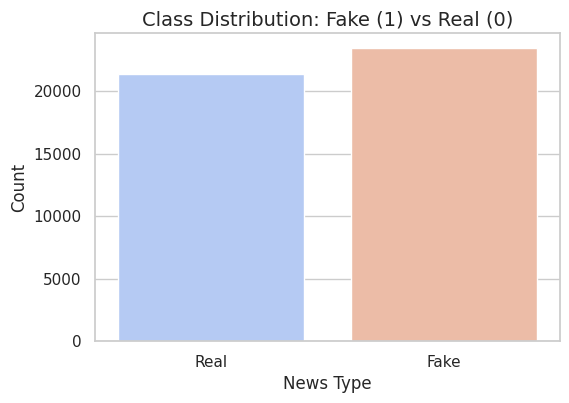

Class Balance Numbers:
label
1    52.298543
0    47.701457
Name: proportion, dtype: float64


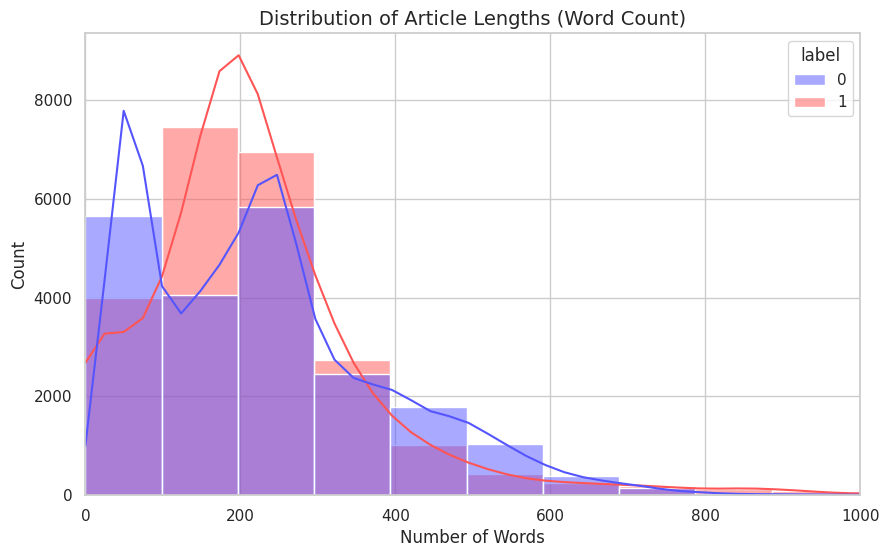


Descriptive Statistics for Word Counts:
         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      21417.0  231.186954  162.395389  0.0   89.0  215.0  312.0  2495.0
1      23481.0  235.257485  234.471378  0.0  134.0  200.0  279.0  4920.0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set(style="whitegrid")

# --- 1. Class Balance Analysis ---
# JUSTIFICATION: Checks if the dataset is biased towards one class.
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_final, palette='coolwarm')
plt.title('Class Distribution: Fake (1) vs Real (0)', fontsize=14)
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()

print("Class Balance Numbers:")
print(df_final['label'].value_counts(normalize=True) * 100)


# --- 2. Text Length Analysis ---
# JUSTIFICATION: Fake news is often shorter/longer than real news. This verifies that hypothesis.
# Calculate word count for every article
df_final['word_count'] = df_final['clean_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='word_count', hue='label', kde=True, bins=50, palette='seismic')
plt.title('Distribution of Article Lengths (Word Count)', fontsize=14)
plt.xlabel('Number of Words')
plt.xlim(0, 1000) # Limiting x-axis to 1000 to ignore extreme outliers for better visibility
plt.show()

# --- 3. Summary Statistics ---
print("\nDescriptive Statistics for Word Counts:")
print(df_final.groupby('label')['word_count'].describe())

Running Rule-Based Classifier...

--- Rule-Based Approach Results ---
Accuracy: 0.6237
              precision    recall  f1-score   support

        Real       0.57      0.87      0.69     21417
        Fake       0.77      0.40      0.53     23481

    accuracy                           0.62     44898
   macro avg       0.67      0.63      0.61     44898
weighted avg       0.67      0.62      0.60     44898



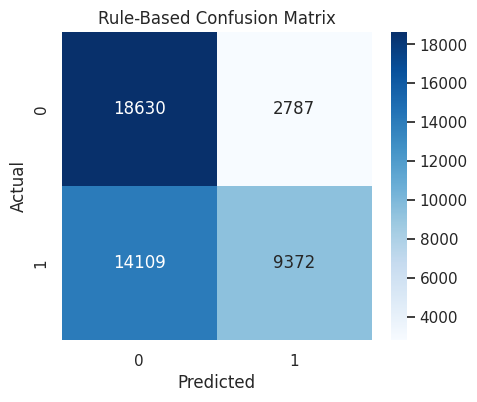

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Define the Lexicon (Rule-Based) ---
# These are "trigger words" often found in clickbait/fake news
suspicious_keywords = [
    'breaking', 'shocking', 'reveal', 'secret', 'conspiracy',
    'banned', 'exposed', 'video', 'watch', 'viral', 'hoax'
]

def rule_based_classifier(text):
    """
    Classifies text as Fake (1) if it contains suspicious keywords.
    Otherwise classifies as Real (0).
    """
    # Simple logic: If any keyword is found, flag as Fake
    for word in suspicious_keywords:
        if word in text.split():
            return 1 # Predicted Fake
    return 0 # Predicted Real

# --- 2. Apply and Evaluate ---
print("Running Rule-Based Classifier...")
# We use the 'clean_text' column from previous steps
y_pred_rules = df_final['clean_text'].apply(rule_based_classifier)
y_true = df_final['label']

print("\n--- Rule-Based Approach Results ---")
print(f"Accuracy: {accuracy_score(y_true, y_pred_rules):.4f}")
print(classification_report(y_true, y_pred_rules, target_names=['Real', 'Fake']))

# Visualize Confusion Matrix for Rules
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_true, y_pred_rules), annot=True, fmt='d', cmap='Blues')
plt.title('Rule-Based Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1. Generating TF-IDF Features...
   Feature Matrix Shape: (44898, 5000)

2. Splitting Data (80% Train, 20% Test)...

3. Training Logistic Regression...
4. Training Random Forest (this may take 2-3 minutes)...

--- RESULTS ---
Logistic Regression Accuracy: 0.9863
Random Forest Accuracy:       0.9974


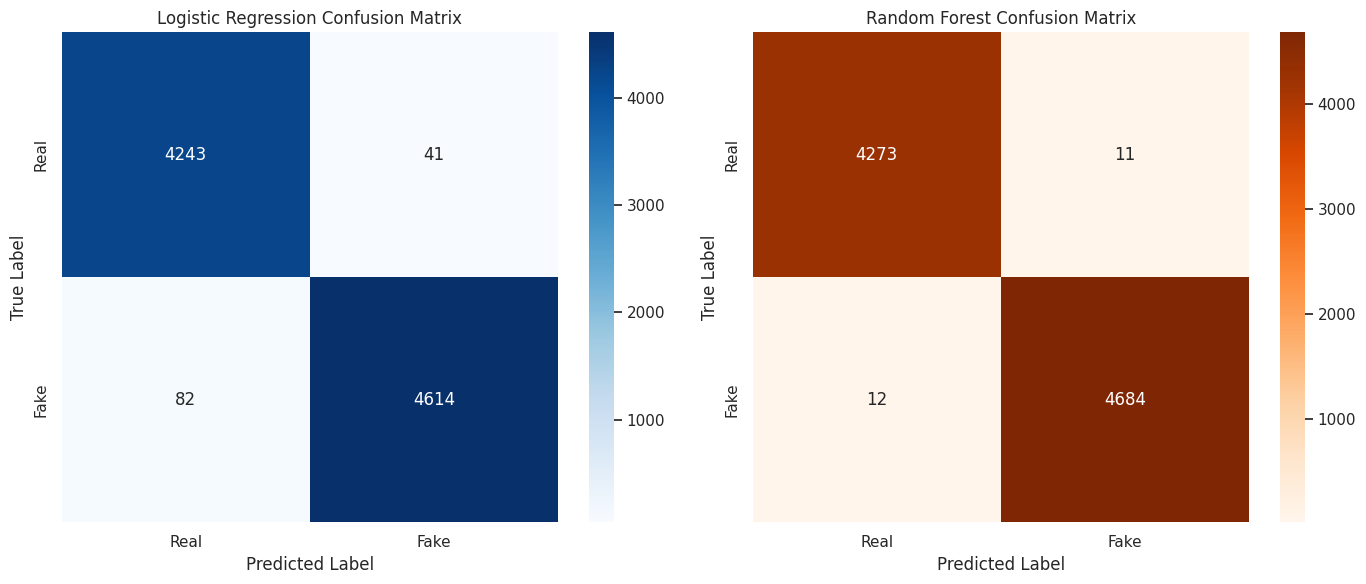


Detailed Report (Random Forest):
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- SAFETY CHECK ---
# Ensure df_final exists from your previous data loading step
if 'df_final' not in locals():
    raise ValueError(" df_final is missing! Please re-run the Data Loading & Cleaning cells first.")

# --- STEP 1: CREATE TF-IDF FEATURES (The Missing Step) ---
print("1. Generating TF-IDF Features...")
# Initialize vectorizer (limit to top 5000 words to save memory)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and Transform the clean text
X_tfidf = tfidf_vectorizer.fit_transform(df_final['clean_text']).toarray()
y = df_final['label']

print(f"   Feature Matrix Shape: {X_tfidf.shape}")

# --- STEP 2: SPLIT DATA ---
print("\n2. Splitting Data (80% Train, 20% Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# --- STEP 3: TRAIN LOGISTIC REGRESSION (Baseline) ---
print("\n3. Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# --- STEP 4: TRAIN RANDOM FOREST (Advanced) ---
print("4. Training Random Forest (this may take 2-3 minutes)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- STEP 5: EVALUATION & VISUALIZATION ---
print("\n--- RESULTS ---")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Random Forest Accuracy:       {accuracy_score(y_test, y_pred_rf):.4f}")

# Plot Confusion Matrices Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(['Real', 'Fake'])
axes[0].set_yticklabels(['Real', 'Fake'])

# Random Forest Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(['Real', 'Fake'])
axes[1].set_yticklabels(['Real', 'Fake'])

plt.tight_layout()
plt.show()

# Print detailed report for the best model (Random Forest)
print("\nDetailed Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Real', 'Fake']))


--- Model Performance Comparison ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.9863     0.9912  0.9825    0.9868   0.9992
Random Forest          0.9974     0.9977  0.9974    0.9976   0.9999


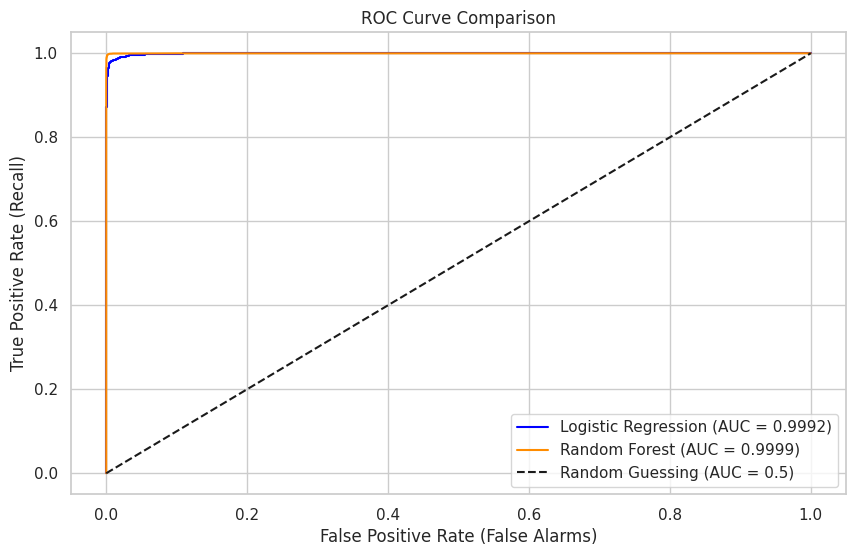

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# --- 1. Generate Probability Scores (Required for ROC-AUC) ---
# We need probabilities, not just hard 0/1 predictions, to calculate ROC-AUC
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]  # Probability of being "Fake" (Class 1)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# --- 2. Define a Helper Function for Metrics ---
def get_metrics(y_true, y_pred, y_prob, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

# --- 3. Calculate Metrics for Both Models ---
metrics_lr = get_metrics(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
metrics_rf = get_metrics(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# Create a comparison dataframe
df_metrics = pd.DataFrame([metrics_lr, metrics_rf])
print("\n--- Model Performance Comparison ---")
print(df_metrics.set_index('Model').round(4))

# --- 4. Visualize ROC Curves ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 6))

# Plot Logistic Regression Curve
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {metrics_lr["ROC-AUC"]:.4f})', color='blue')

# Plot Random Forest Curve
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {metrics_rf["ROC-AUC"]:.4f})', color='darkorange')

# Plot Diagonal (Random Guessing Line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

 Generating predictions and probabilities...

---  FINAL PERFORMANCE METRICS ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.9863     0.9912  0.9825    0.9868   0.9992
Random Forest          0.9974     0.9977  0.9974    0.9976   0.9999

 Generating Visualization 1: Confusion Matrices...


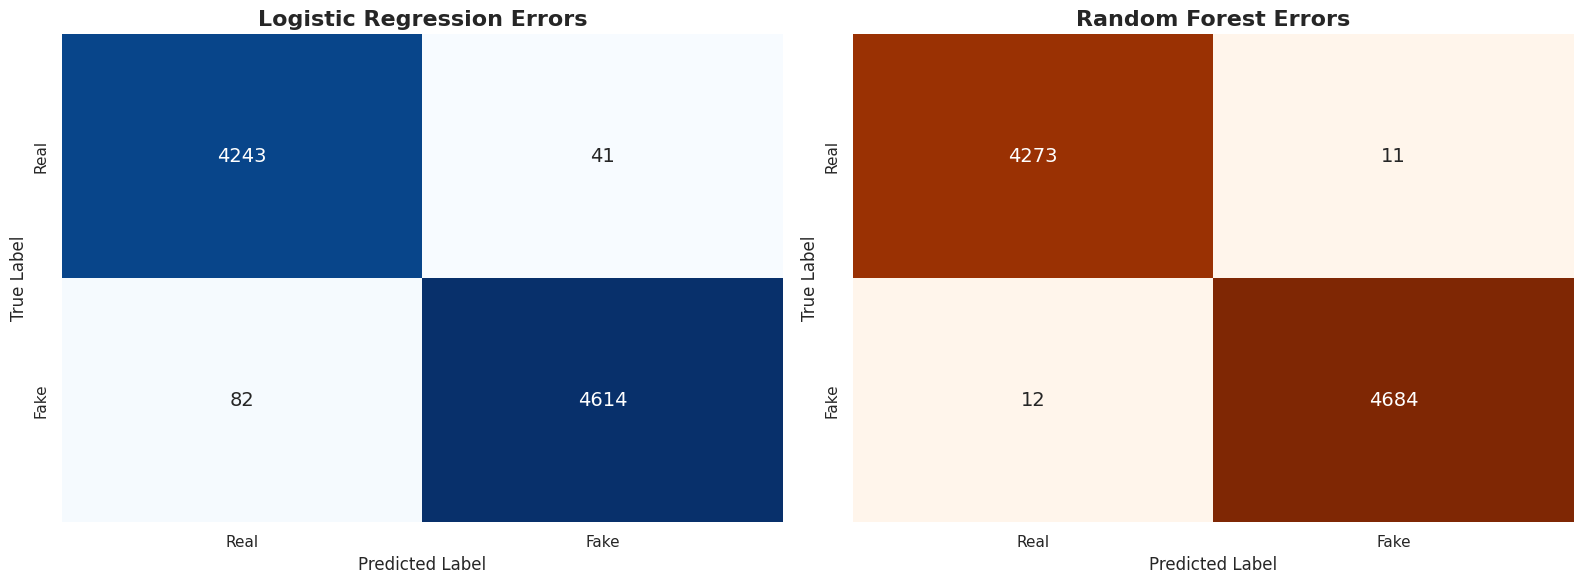


 Generating Visualization 2: ROC Curves...


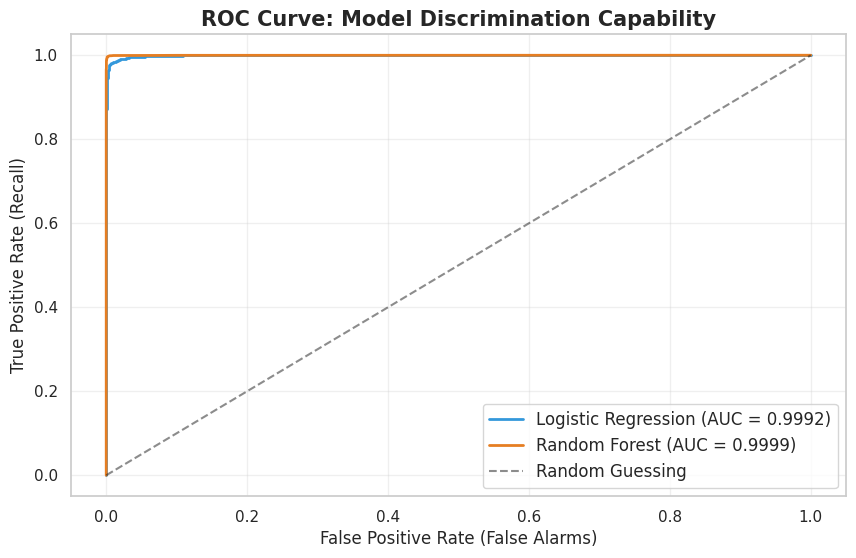


 Generating Visualization 3: Precision-Recall Curves...


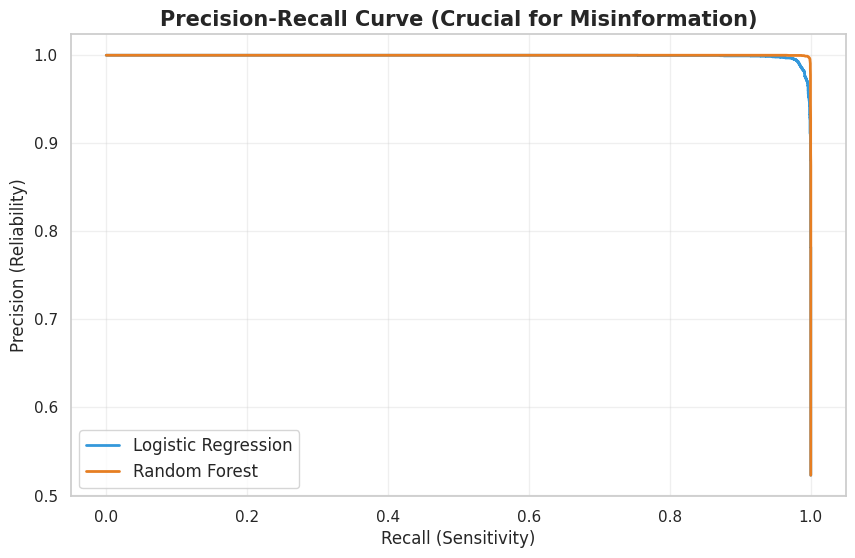


 Generating Visualization 4: Top 20 Important Words...


/tmp/ipython-input-2469206258.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Word', data=feat_df, palette='viridis')


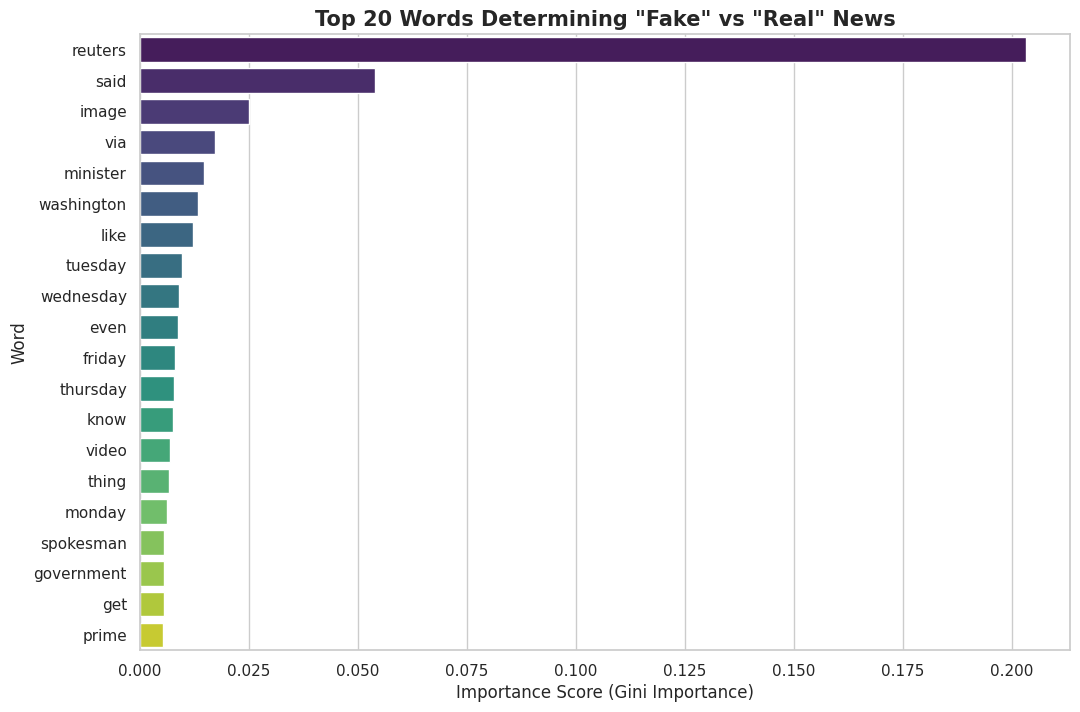

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
)

# Set the aesthetic style for the plots
sns.set(style="whitegrid")

# --- 1. PREPARATION: Generate Predictions & Probabilities ---
# We need probabilities (0.0 to 1.0) for ROC and PR curves
print(" Generating predictions and probabilities...")
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# --- 2. METRICS CALCULATION ---
def calculate_metrics(y_true, y_pred, y_prob, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

metrics_df = pd.DataFrame([
    calculate_metrics(y_test, y_pred_lr, y_prob_lr, "Logistic Regression"),
    calculate_metrics(y_test, y_pred_rf, y_prob_rf, "Random Forest")
])

print("\n---  FINAL PERFORMANCE METRICS ---")
print(metrics_df.set_index('Model').round(4))

# --- 3. VISUALISATION 1: Side-by-Side Confusion Matrices ---
print("\n Generating Visualization 1: Confusion Matrices...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Logistic Regression Heatmap
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False, annot_kws={"size": 14})
axes[0].set_title('Logistic Regression Errors', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['Real', 'Fake'])
axes[0].set_yticklabels(['Real', 'Fake'])

# Random Forest Heatmap
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar=False, annot_kws={"size": 14})
axes[1].set_title('Random Forest Errors', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticklabels(['Real', 'Fake'])
axes[1].set_yticklabels(['Real', 'Fake'])

plt.tight_layout()
plt.show()

# --- 4. VISUALISATION 2: ROC Curve Comparison ---
print("\n Generating Visualization 2: ROC Curves...")
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {metrics_df.loc[0, "ROC-AUC"]:.4f})', color='#3498db', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {metrics_df.loc[1, "ROC-AUC"]:.4f})', color='#e67e22', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', alpha=0.5)

plt.xlabel('False Positive Rate (False Alarms)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve: Model Discrimination Capability', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. VISUALISATION 3: Precision-Recall Curves ---
print("\n Generating Visualization 3: Precision-Recall Curves...")
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label='Logistic Regression', color='#3498db', linewidth=2)
plt.plot(recall_rf, precision_rf, label='Random Forest', color='#e67e22', linewidth=2)

plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (Reliability)', fontsize=12)
plt.title('Precision-Recall Curve (Crucial for Misinformation)', fontsize=15, fontweight='bold')
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# --- 6. VISUALISATION 4: Feature Importance (Explainability) ---
# Check if we can extract feature names
if hasattr(rf_model, 'feature_importances_') and 'tfidf_vectorizer' in locals():
    print("\n Generating Visualization 4: Top 20 Important Words...")

    # Get feature names and importance scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    importances = rf_model.feature_importances_

    # Create a dataframe for plotting
    feat_df = pd.DataFrame({'Word': feature_names, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Word', data=feat_df, palette='viridis')
    plt.title('Top 20 Words Determining "Fake" vs "Real" News', fontsize=15, fontweight='bold')
    plt.xlabel('Importance Score (Gini Importance)', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.show()
else:
    print("Skipping Feature Importance: Vectorizer or Model not accessible.")